## Shapefile with Polylines of Water-Level Contours 
<br>
Created by Brandon Tucker in 2023, modified by Casey Dietrich in 2024.<br>
<br>
This example will show how to create a shapefile from ADCIRC outputs.<br>
<br>
This is a straightforward conversion of the ADCIRC outputs. We do not do any downscaling -- that will be demonstrated in later examples.<br>
<br>
We will create contours with polylines (not polygons) based on the maximum water levels from ADCIRC, then export those polylines as a shapefile. This is an alternative feature of <code>nc2shp</code> that we want to showcase.<br>
<br>
We use files from a simulation of Hurricane Ida, which devastated the south Louisiana coast in 2021. To minimize the file sizes in this repository, we created a small mesh that includes Grand Isle and Barataria Bay. Then we simulated Ida by using the NHC best-track storm parameters in a vortex wind model. The simulated storm effects are meant to be useful as an example, but they should not be relied on for any decision making.

## Preliminaries

In [1]:
import os
import numpy as np
import netCDF4 as netcdf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from kalpana.export import nc2shp
from kalpana.plotting import plot_nc, plot_kalpana_gdf

## Maximum Water Levels

First, let's look at the <code>maxele.63.nc</code> file, which contains the maximum water level at every mesh vertex throughout the simulation. This file is an output of ADCIRC, and it is a key input to Kalpana. The following cell creates a visualization of the maximum water levels for Ida.

<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

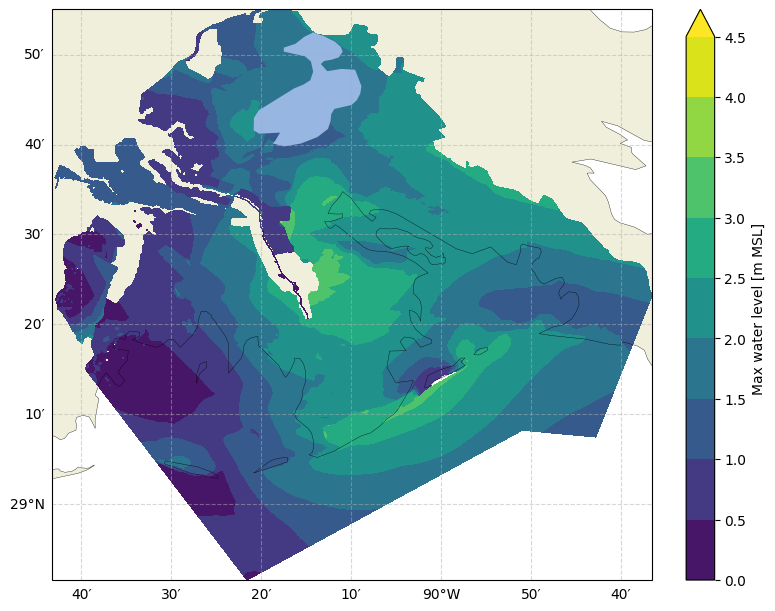

In [4]:
## Path to netcdf file.
nc_file = r'../../adds/ida/maxele.63.nc' 
nc = netcdf.Dataset(nc_file)

## Flood levels to plot: min, max, step
levels = np.arange(0, 5, 0.5)

# Visualize the netcdf file.
plot_nc(nc, 'zeta_max', levels, cbar = True, cb_label = 'Max water level [m MSL]',
        background_map=True, extend='max')

Next, we use the <code>nc2shp</code> function to create contours based on these maximum water levels. The following cell defines our parameters for this function.

In [5]:
######## For more detail about the nc2shp inputs, please read the function's docstring.

## Path of the ADCIRC maxele output file, must be a netcdf file.
ncFile = r'../../adds/ida/maxele.63.nc' 

## Name of the maxele variable to downscale.
var = 'zeta_max'

## Contour levels: min, max, step. Max is included as in np.arange method. Values must be in vUnitOut vertical unit.
## from 0 to 5.5 m (included) every 0.5 m.
levels = [0, 5.5, 0.5]

## We are creating polylines in this example.
conType = 'polyline' ## 'polyline' or 'polygon'

## Complete path of the output file (*.shp or *.gpkg).
pathOut = 'water_level_contours_as_polylines.gpkg'

## Coordinate system of the output shapefile.
epsgOut = 4326  # Output in latitude and longitude.

## Input and output vertical units, for the momment only supported 'm' and 'ft'. 
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'

## Coordinate system of the ADCIRC input.
## Default is 4326 because ADCIRC uses latitude and longitude.
epsgIn = 4326  

## Complete path of the subdomain polygon kml or shapefile, or list with the
## upper-left x, upper-left y, lower-right x and lower-right y coordinates. 
## The crs must be the same of the ADCIRC input file. 
subDomain = None ## Default None

## True for export the mesh geodataframe and also save it as a shapefile. 
## For this example, we are only exporting the contours, not the mesh.
exportMesh = False ## Default False

## File name of the output mesh shapefile.
meshName = None ## Default None

## Full path of the pickle file with the vertical difference between datums for each mesh node. 
dzFile = None ## Default None

## Threshold for using nearest neighbor interpolation to change datum. Points below this value won't be changed.
zeroDif = -20 ## Default -20

## Threshold to define the percentage of the dz given by the spatial interpolation to be applied.
maxDif = -5

## Distance threshold for limiting the inverse distance-weighted (IDW) interpolation.
distThreshold = 0.5

## Number of points return in the kdtree query.
k = 7

## Timesteps to extract if working with a time-varying ADCIRC output file.
timesteps = None

Now, let's call the <code>nc2shp</code> function with the parameters we defined. Note that the output shapefile will also be saved to the path specified in the <code>pathOut</code> parameter.

In [6]:
## Call nc2shp() and store output as geodataframe.
gdf = nc2shp(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
           subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,
           maxDif=maxDif, distThreshold=distThreshold, k=k, timesteps=timesteps)

2024-07-23 10:48:34.696 | INFO     | kalpana.export:nc2shp:817 - Start exporting adcirc to shape
2024-07-23 10:48:35.198 | INFO     | kalpana.export:contours2gpd:372 - Begin computing contours using Dask
2024-07-23 10:48:35.203 | INFO     | kalpana.export:contours2gpd:374 - Finish computing contours using Dask
2024-07-23 10:48:35.208 | INFO     | kalpana.export:nc2shp:847 -     Ready with the contours extraction: 0.008 min
2024-07-23 10:48:35.255 | INFO     | kalpana.export:nc2shp:884 -     Saving file: 0.001 min
2024-07-23 10:48:35.255 | INFO     | kalpana.export:nc2shp:901 - Ready with exporting code after: 0.009 min


We can visualize the polyline contours by plotting them from the geodataframe, by using the <code>plot_kalpana_gdf</code> function.

<GeoAxesSubplot: >

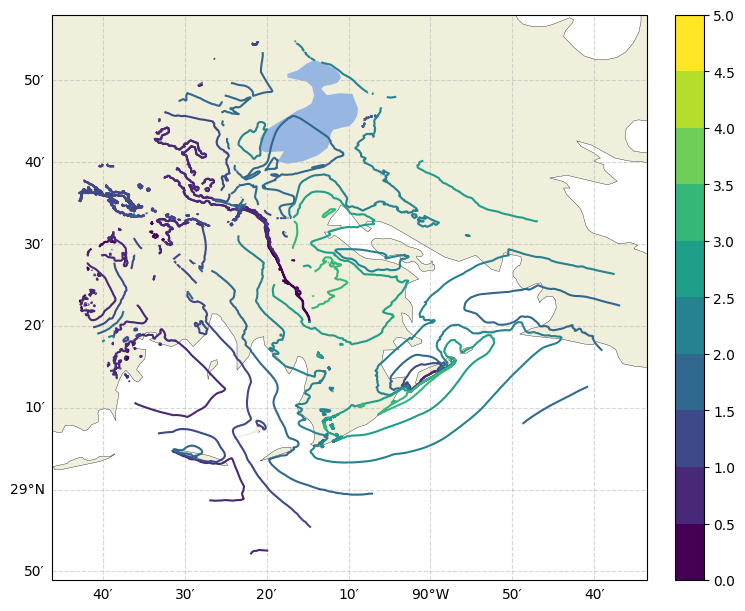

In [7]:
plot_kalpana_gdf(gdf, levels = np.arange(0, 5.5, 0.5), var = 'z')

We can look at the original maximum flooding levels and the polylines we generated side-by-side.

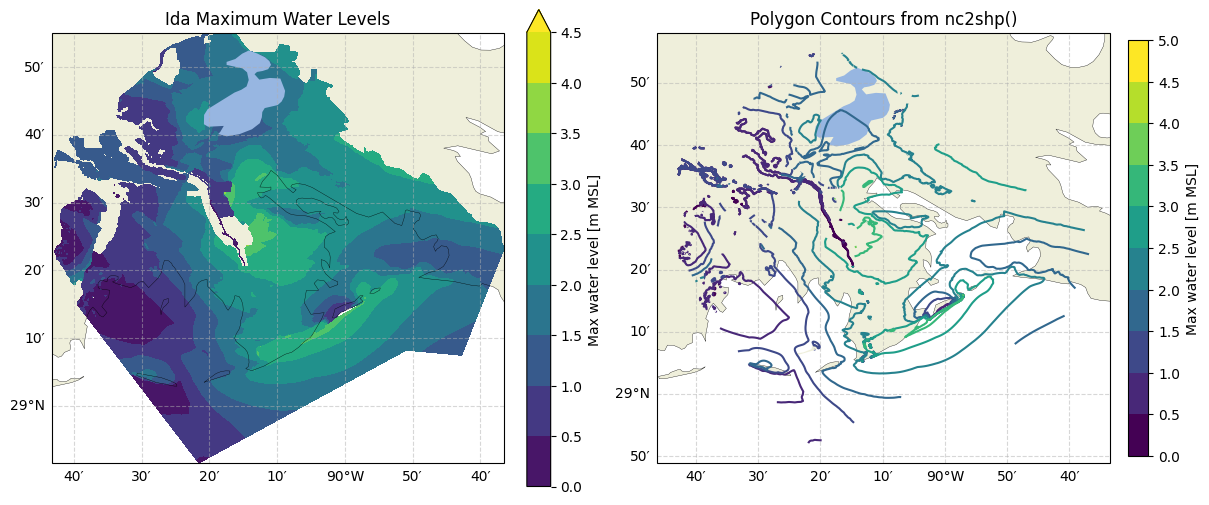

In [8]:
# Create two subplots.
fig, ax = plt.subplots(figsize = (12, 5), nrows = 1, ncols = 2,  subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Visualize the netcdf file.
plot_nc(nc, 'zeta_max', np.arange(0, 5, 0.5), cbar = True, cb_label = 'Max water level [m MSL]',
        background_map=True, ax = ax[0], fig = fig, extend='max')
ax[0].set_xlabel('Longitude [deg]')
ax[0].set_ylabel('Latitude [deg]')
ax[0].set_title('Ida Maximum Water Levels')

# Visualize polylines.
plot_kalpana_gdf(gdf, np.arange(0, 5.5, 0.5), var = 'z', ax = ax[1], fig = fig, fsize = (8,6), cbar = True, 
          cbar_label = 'Max water level [m MSL]')
ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')
ax[1].set_title('Polygon Contours from nc2shp()');

Finally, we can overlay original maximum flooding levels and the polylines we generated side-by-side.

Text(0.5, 1.0, 'Ida Maximum Water Levels')

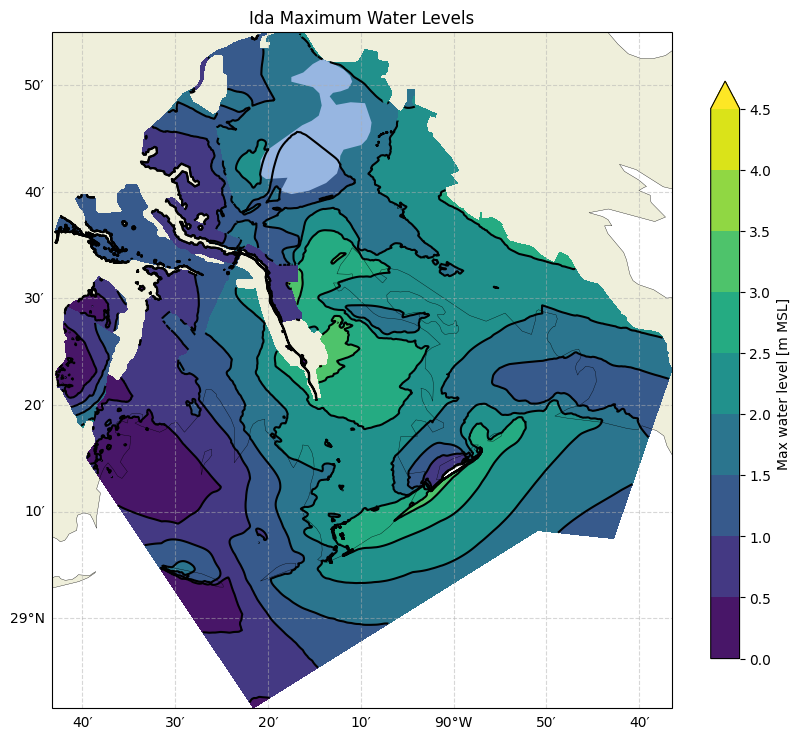

In [10]:
# Create two subplots.
fig, ax = plt.subplots(figsize = (10, 10),  subplot_kw={'projection': ccrs.PlateCarree()})

# Visualize the netcdf file.
ax = plot_nc(nc, 'zeta_max', np.arange(0, 5, 0.5), cbar = True, cb_label = 'Max water level [m MSL]',
        background_map=True, ax = ax, fig = fig, extend='max', cb_shrink=0.75)

gdf.plot(ax = ax, color = 'k')

ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Ida Maximum Water Levels')

## Housekeeping

The following cell is optional. We include it to keep clean the repository -- it will delete the shapefile that we just created. For most users, this cell is not necessary.

In [11]:
## clean
os.remove(pathOut)

Good luck with Kalpana! See you in future examples!